# IRD 2021-2022 - HAL Data processing

In [22]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import unidecode
import json
import re
from typing import Any, Dict, List, Callable
import textwrap

# Constants

Define primary constants

* `LAB_STRUCT_ID` : The identifier in HAL of the CES (15080)
* `NON_ALPHA_NUMERIC_REGEX` : Regex to cleanup all non alpha numeric characters
* `JSON_FILENAME` : Extration from HAL API.

In [23]:
LAB_STRUCT_ID = 15080
NON_ALPHA_NUMERIC_REGEX = re.compile('[^a-z0-9_-]', re.IGNORECASE)
JSON_FILENAME = './result.2022-10-16T15-36.json'

#  Datasets

This dataset has been saved by another notebook : `load-json-data-file.ipynb`

Here, we just load the data. For more information, see [./load-json-data-file.ipynb](./load-json-data-file.ipynb) another


## HAL APIs

### Load HAL API results

Load the HAP API results from filaneme named `JSON_FILENAME`

In [25]:
with open(JSON_FILENAME, 'r') as fp:
    data = json.load(fp)
df = pd.DataFrame.from_dict(data['response']['docs'])
df

,label_s,openAccess_bool,journalTitle_s,journalIssn_s,authLastName_s,authFirstName_s,authFullName_s,authIdFullName_fs,authIdHasPrimaryStructure_fs,authIdHasStructure_fs,...,anrProjectTitle_s,anrProjectAcronym_s,anrProjectReference_s,authIdHal_i,funding_s,files_s,authStructId_i,jel_s,europeanProjectAcronym_s,europeanProjectReference_s
0,"Noélie Delahaie, Coralie Perez. Workforce adju...",False,Industrial Relations Journal,0019-8692,"[Delahaie, Perez]","[Noélie, Coralie]","[Noélie Delahaie, Coralie Perez]","[0_FacetSep_Noélie Delahaie, 0_FacetSep_Corali...",[600166-0_FacetSep_Noélie Delahaie_JoinSep_461...,[600166-0_FacetSep_Noélie Delahaie_JoinSep_461...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Olivier Chanel, Stéphanie Vincent Lyk-Jensen, ...",False,Defence and Peace Economics,1024-2694,"[Chanel, Lyk-Jensen, Vergnaud]","[Olivier, Stéphanie Vincent, Jean-Christophe]","[Olivier Chanel, Stéphanie Vincent Lyk-Jensen,...","[742185_FacetSep_Olivier Chanel, 823994_FacetS...",[38532-742185_FacetSep_Olivier Chanel_JoinSep_...,[38532-742185_FacetSep_Olivier Chanel_JoinSep_...,...,[Décision en présence d'incertitude et d'émoti...,"[RISKEMOTION, AMSE (EUR), Amidex]","[ANR-08-RISK-0007, ANR-17-EURE-0020, ANR-11-ID...","[742185, 823994, 11191]",[Soldaterlegatet with financial support from T...,NaN,NaN,NaN,NaN,NaN
2,"Thomas Barnay, Éric Defebvre. La retraite : un...",True,LIEPP Policy Brief,NaN,"[Barnay, Defebvre]","[Thomas, Éric]","[Thomas Barnay, Éric Defebvre]","[669_FacetSep_Thomas Barnay, 173381_FacetSep_É...",[15539-669_FacetSep_Thomas Barnay_JoinSep_4207...,[15539-669_FacetSep_Thomas Barnay_JoinSep_4207...,...,[Center for the Interdisciplinary Evaluation o...,"[LIEPP, Université de Paris]","[ANR-10-LABX-0091, ANR-18-IDEX-0001]","[669, 173381]",NaN,[https://hal-sciencespo.archives-ouvertes.fr/h...,NaN,NaN,NaN,NaN
3,"Rémy Herrera, Zhiming Long, Zhixuan Feng, Bang...",False,Recherches Internationales,0294-3069,"[Herrera, Long, Feng, Li]","[Rémy, Zhiming, Zhixuan, Bangxi]","[Rémy Herrera, Zhiming Long, Zhixuan Feng, Ban...","[0_FacetSep_Rémy Herrera, 0_FacetSep_Zhiming L...",[178535-0_FacetSep_Rémy Herrera_JoinSep_15080_...,[178535-0_FacetSep_Rémy Herrera_JoinSep_15080_...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Christophe Chorro, Rahantamialisoa Fanirisoa. ...",True,Journal of Financial Econometrics,1479-8409,"[Chorro, Fanirisoa]","[Christophe, Rahantamialisoa]","[Christophe Chorro, Rahantamialisoa Fanirisoa]","[16609_FacetSep_Christophe Chorro, 185092_Face...",[5766-16609_FacetSep_Christophe Chorro_JoinSep...,[5766-16609_FacetSep_Christophe Chorro_JoinSep...,...,NaN,NaN,NaN,"[16609, 185092]",NaN,NaN,[15080],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,"Hannes Schwandt, Janet Currie, Marlies Bär, Ja...",True,Proceedings of the National Academy of Science...,0027-8424,"[Schwandt, Currie, Bär, Banks, Bertoli, Bütiko...","[Hannes, Janet, Marlies, James, Paola, Aline, ...","[Hannes Schwandt, Janet Currie, Marlies Bär, J...","[795515_FacetSep_Hannes Schwandt, 795514_Facet...",[13554-6560_FacetSep_Josselin Thuilliez_JoinSe...,[13554-6560_FacetSep_Josselin Thuilliez_JoinSe...,...,NaN,NaN,NaN,"[795515, 795514, 809290, 809291, 809292, 80929...",NaN,[https://halshs.archives-ouvertes.fr/halshs-03...,NaN,NaN,NaN,NaN
147,Bruno Tinel. Les ménages au cœur de la financi...,False,Actuel Marx,0994-4524,[Tinel],[Bruno],[Bruno Tinel],[12661_FacetSep_Bruno Tinel],[4147-12661_FacetSep_Bruno Tinel_JoinSep_15080...,[4147-12661_FacetSep_Bruno Tinel_JoinSep_15080...,...,NaN,NaN,NaN,[12661],NaN,[https://halshs.archives-ouvertes.fr/halshs-03...,[7550],NaN,NaN,NaN
148,Franz Dietrich. Categorical versus graded beli...,True,Frontiers in Psychology,NaN,[Dietrich],[Franz],[Franz Dietrich],[6630_FacetSep_Franz Dietrich],[28373-6630_FacetSep_Franz Dietrich_JoinSep_30...,[28373-6630_FacetSep_Franz Dietrich_JoinSep_30...,...,"[Appréhender des Opinions Hétérogènes, La form...","[CHOp, ColAForm, PGSE]","[

### Stats

View some minor stats on non nan row for each columns

In [26]:
# List all non nan row for each columns
df.count().to_frame().to_csv('./exports/rows-having-values.csv', index=True)
df.count().to_frame()

,0
label_s,151
openAccess_bool,151
journalTitle_s,151
journalIssn_s,133
authLastName_s,151
authFirstName_s,151
authFullName_s,151
authIdFullName_fs,151
authIdHasPrimaryStructure_fs,151
authIdHasStructure_fs,151


## Authors Datasets

In this section, we will work on the authors to find all forms of the authors


### Authors and structure...

As an author may have multiple structures, the number of items in `auth*` columns will not be the same !

We will have the same length in the following list :

* `authId_i`, `authLastName_s`, `authFirstName_s`, `authFullName_s`
* `authStructId_i`, `authIdHasPrimaryStructure_fs`

But the length of list `authId_i` and `authStructId_i` may be different.

We will use the facet `authIdHasPrimaryStructure_fs` to correlate an author with its `authStructId_i`.

In [34]:
# Cleanup useles columns for authors and explode on same list length
authors = df[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'authIdHasPrimaryStructure_fs']]
authors = authors.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])
authors = authors.explode(['authIdHasPrimaryStructure_fs'])

authors = authors[authors.apply(lambda r: r.authFullName_s in r.authIdHasPrimaryStructure_fs, axis=1)]
authors = authors.drop(columns=['authIdHasPrimaryStructure_fs']).drop_duplicates(ignore_index=True)
authors

,authLastName_s,authFirstName_s,authFullName_s
0,Delahaie,Noélie,Noélie Delahaie
1,Perez,Coralie,Coralie Perez
2,Chanel,Olivier,Olivier Chanel
3,Vergnaud,Jean-Christophe,Jean-Christophe Vergnaud
4,Barnay,Thomas,Thomas Barnay
...,...,...,...
257,Daff,Bocar Mamadou,Bocar Mamadou Daff
258,Diouf,Serigne,Serigne Diouf
259,Fall Dia,Khadidiatou,Khadidiatou Fall Dia
260,Nakamura,Ryota,Ryota Nakamura


In [43]:
# Cleanup useles columns for authors and explode on same list length
authors = df[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'authIdHasPrimaryStructure_fs']]
authors = authors.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])
authors = authors.explode(['authIdHasPrimaryStructure_fs'])
# Correlate authIdHasPrimaryStructure_fs with author fullname
authors = authors[authors.apply(lambda r: r.authFullName_s in r.authIdHasPrimaryStructure_fs, axis=1)]
authors = authors.drop(columns=['authIdHasPrimaryStructure_fs']).drop_duplicates(ignore_index=True)
# Save authors in CSV
authors.to_csv(f'./exports/all-authors.csv', index=False)
# Show authors head
authors.head(n=5)

,authLastName_s,authFirstName_s,authFullName_s
0,Delahaie,Noélie,Noélie Delahaie
1,Perez,Coralie,Coralie Perez
2,Chanel,Olivier,Olivier Chanel
3,Vergnaud,Jean-Christophe,Jean-Christophe Vergnaud
4,Barnay,Thomas,Thomas Barnay


## Rerefentials Datasets

### Econlit

EconLit referential is available at https://www.aeaweb.org/econlit/journal_list.php .

A JSON Datasets can be extract from a web browser (such as Chrome or Firefox) using the simple following commands in a web console:

```javascript
$$('.journaldesc')
  .map(item => $(item).text().split('\n'))
  .map(arr => Object.assign(
    { Title: arr[0].trim() },
    Object.fromEntries(
      arr
      .slice(1)
      .map(val => val.trim())
      .map(line => [
        line.split(':', 1).join().trim(),
        line.split(':').slice(1).join(':').trim()
      ]))
  ));
```

This will extract all the required code in a object that can be copy/paste into a JSON file

**Note 1 :** It's possible to have some ISSN duplicated here. For example, `0013-0117` have several titles (_Economic History Review_ or _Economic History Review, Second Series_)

**Note 2 :** For formating purpose, `$$` should be replace with a single `$`

In [44]:
econlit_df = pd.read_json('./ref.econlit.json').drop(columns=['EconLit Coverage', 'Formerly','See'])
print(f'Econlit original size : {econlit_df["Title"].size}')
# Cleaning data
econlit_df['ISSN'] = econlit_df['ISSN'].transform(lambda x: x.strip())
econlit_df = econlit_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
print(f'Econlit size after droping duplicates : {econlit_df["Title"].size}')
econlit_df

Econlit original size : 2028
Econlit size after droping duplicates : 1900


,Title,ISSN
0,4OR: A Quarterly Journal of Operations Research,1619-4500
1,Academia Economic Papers,1018-161X
2,"Accounting, Business and Financial History",0958-5206
3,"Accounting, Economics, and Law: A Convivium",2194-6051
4,Accounting History Review,2155-2851
...,...,...
1895,Zeitschrift für Wirtschafts- und Sozialwissens...,0342-1783
1896,Zeitschrift für Wirtschafts- und Unternehmense...,1439-880X
1897,Zeitschrift für Wirtschaftspolitik,0721-3808
1898,Zeitschrift fur offentliche und gemeinwirtscha...,0344-9777


### MathSciNet

MathSciNet referential is available at https://mathscinet.ams.org/mathscinet/mrcit/journal_list.html

A JSON Datasets can be extract from browser using the simple following commands in a web console:

```javascript
$$('table tr')
  .map(i => $(i).find('td'))
  .filter(a => a.length === 4)
  .map(a => ({
    ISSN: $(a[0]).text().trim(),
    Title: $(a[1]).text().trim(),
    Publisher: $(a[2]).text().trim(),
    Start_Year: $(a[3]).text().trim()
  }))
```

**Note 1:** We may have duplicates in `ISSN` columns

In [47]:
mathscinet_df = pd.read_json('./ref.mathscinet.json').drop(columns=['Publisher', 'Start_Year'])
print(f'MathSciNet original size : {mathscinet_df["Title"].size}')
mathscinet_df['ISSN'] = mathscinet_df['ISSN'].transform(lambda x: x.strip())
mathscinet_df = mathscinet_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
print(f'MathSciNet size after cleaning duplicates : {mathscinet_df["Title"].size}')
mathscinet_df

MathSciNet original size : 769
MathSciNet size after cleaning duplicates : 621


,ISSN,Title
0,0271-4132,Contemp. Math.
1,0302-9743,Lecture Notes in Comput. Sci.
2,0160-7634,Proc. Sympos. Appl. Math.
3,0082-0717,Proc. Sympos. Pure Math.
4,0025-5858,Abh. Math. Semin. Univ. Hambg.
...,...,...
616,0165-2125,Wave Motion
617,0044-2267,ZAMM Z. Angew. Math. Mech.
618,0232-2064,Z. Anal. Anwend.
619,0044-2275,Z. Angew. Math. Phys.


### Scimago

A CSV is already available on the [scimago website](https://www.scimagojr.com/journalrank.php) and can be donwload with the following links: https://www.scimagojr.com/journalrank.php?out=xls


**Note :** The `Issn` columns may contains multiples ISSN 

In [48]:
scimagojr_df = pd.read_csv('./ref.scimagojr_2021.csv', sep=';')[['Title', 'Issn', 'Categories', 'SJR Best Quartile']]
scimagojr_df = scimagojr_df.rename(columns={'Issn': 'ISSNs', 'SJR Best Quartile': 'SJR_BEST_QUARTILE', 'Categories': 'CATEGORIES'})
print(f'Scimago original size : {scimagojr_df["Title"].size}')

scimagojr_df['ISSN'] = scimagojr_df['ISSNs'].apply(lambda x: x.split(','))
scimagojr_df = scimagojr_df.explode('ISSN')
print(f'Scimago size after exploding "ISSNs" columns : {scimagojr_df["Title"].size}')

scimagojr_df['ISSN'] = scimagojr_df['ISSN'].transform(lambda x: '-'.join(textwrap.wrap(x.strip(),4)))
scimagojr_df = scimagojr_df.drop(columns=['ISSNs']).drop_duplicates(subset=['ISSN'], ignore_index=True)
print(f'Scimago size after exploding "ISSNs" and droping duplicates : {scimagojr_df["Title"].size}')

scimagojr_df

Scimago original size : 27339
Scimago size after exploding "ISSNs" columns : 43409
Scimago size after exploding "ISSNs" and droping duplicates : 43368


,Title,CATEGORIES,SJR_BEST_QUARTILE,ISSN
0,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,1542-4863
1,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,0007-9235
2,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0072
3,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0080
4,Quarterly Journal of Economics,Economics and Econometrics (Q1),Q1,0033-5533
...,...,...,...,...
43363,WSEAS Transactions on Information Science and ...,Computer Science Applications; Information Sys...,-,1790-0832
43364,WSEAS Transactions on Systems,Computer Science Applications; Control and Sys...,-,1109-2777
43365,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,2544-8730
43366,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,1897-0788


### HCERES

Arf, this is most painfull format (a old school PDF) ! This should be done (almost) manually...

The current file is available here:
https://www.hceres.fr/sites/default/files/media/downloads/hceres_2021_liste_domaine_shs1_economie_et_gestion.pdf

**Steps :**

* Extract a flat text of the PDF
* Remove useles data such as the presentation, the page numbers, ...
* Replace using regex :
  * Searched: `^(.{9})\s+(.*)\s+([^\s]+)\s+([^\s]+)\s+([^\s]+)\s?$`
  * Replacement: `{"ISSN":"$1", "Title": "$2", "CoNRS_2020": "$3"; "FNEGE_2019": "$4", "HCERES_2021": "$5" },`
* Remove the `,` char at the end of the document
* Append `[` char at the beginning and `]` at the end of the document

**Note :** We may have duplicates in `ISSN` columns

In [49]:
hceres_df = pd.read_json('./ref.hceres.json')
print(f'HCERES original size : {hceres_df["Title"].size}')

hceres_df['ISSN'] = hceres_df['ISSN'].transform(lambda x: x.strip())
hceres_df = hceres_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
hceres_df = hceres_df.replace('-', np.nan)
print(f'HCERES size after cleaning duplicates : {mathscinet_df["Title"].size}')

hceres_df

HCERES original size : 937
HCERES size after cleaning duplicates : 621


,ISSN,Title,CoNRS_2020,FNEGE_2019,HCERES_2021
0,2034-9130,@GRH,NaN,3,B
1,1619-4500,4OR: A Quarterly Journal of Operations Research,3,NaN,B
2,0001-3072,Abacus,3,2,A
3,1941-6520,Academy of Management Annals,2,1,A
4,0001-4273,Academy of Management Journal,1,1,A
...,...,...,...,...,...
919,1011-4548,World Competition. Law and Economics Review,3,NaN,B
920,0305-750X,World Development,1,NaN,A
921,0378-5920,World Economy,2,NaN,A
922,1474-7456,World Trade Review,4,NaN,C


# Data Processing

## Keywords

Count the number of keywords for all articles

In [50]:
keywords = df.explode('keyword_s')
keywords = keywords[['keyword_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
keywords.to_csv(path_or_buf='./exports/keywords.csv', index=False)
print(f'Number of articles without keywords : {keywords[keywords.keyword_s.isnull()]["count"].sum()}')
print(f'Number of keywords : {keywords["keyword_s"].dropna().size}')
keywords.head(n=5)

Number of articles without keywords : 60
Number of keywords : 418


,keyword_s,count
0,NaN,60
1,Metacognition,5
2,Confidence,4
3,Stochastic Volterra equations,3
4,France,3


In [59]:
top_count_keywords = keywords.dropna()
top_count_keywords = top_count_keywords[top_count_keywords['count'] >= 3].sort_values(by=['count']).reset_index().sort_values(by=['count'], ascending=False)
top_count_keywords

,index,keyword_s,count
5,1,Metacognition,5
4,2,Confidence,4
0,3,Stochastic Volterra equations,3
1,4,France,3
2,5,Gender inequality,3
3,6,Fairness,3


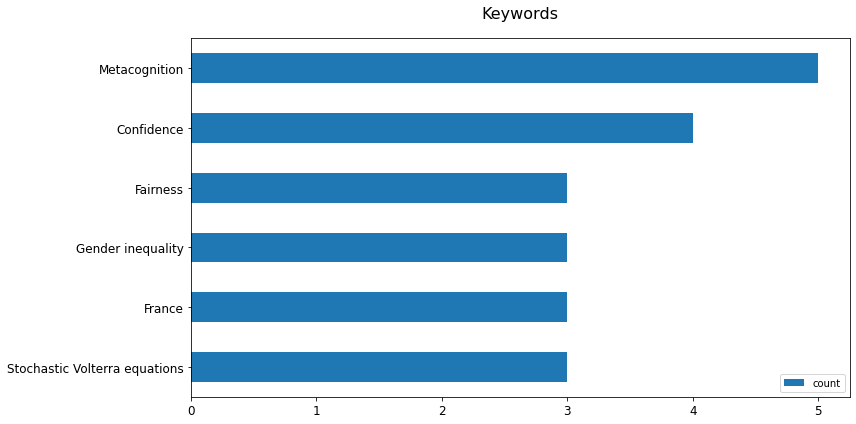

In [60]:
p = top_count_keywords.sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Keywords',
    x='keyword_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 6),
    rot=0,
    fontsize=12
)
p.set_title('Keywords', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/keywords_repartition.png')

## Journals

### Journals occurrences 

In [61]:
journals = df[['journalTitle_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
journals.to_csv(path_or_buf='./exports/journals.csv', index=False)
print(f'Number of journals : {journals["journalTitle_s"].size}')
journals.head(n=5)

Number of journals : 107


,journalTitle_s,count
0,Journal of Economic Behavior and Organization,9
1,Public Choice,5
2,Journal of Mathematical Economics,4
3,La Lettre du CEPII,3
4,European Economic Review,3


In [64]:
top_count_journals = journals[journals['count'] >= 3].sort_values(by=['count'], ascending=False)
top_count_journals

,journalTitle_s,count
0,Journal of Economic Behavior and Organization,9
1,Public Choice,5
2,Journal of Mathematical Economics,4
3,La Lettre du CEPII,3
4,European Economic Review,3


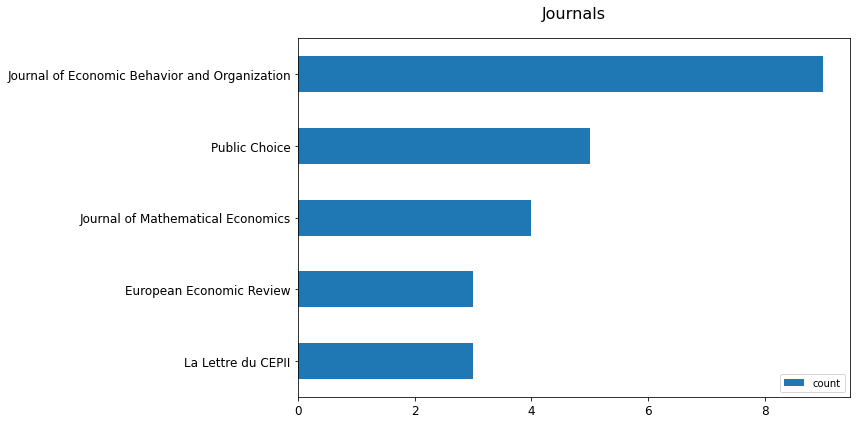

In [66]:
p = top_count_journals.sort_values(by=['count']).plot(
    kind='barh',
    title='Journals',
    x='journalTitle_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 6),
    fontsize=12
)
p.set_title('Journals', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/journals_repartition.png')

### Journal without ISSN

In [67]:
journal_without_issns = df[df.journalIssn_s.isnull()][['uri_s', 'journalTitle_s']].reset_index(drop=True)
journal_without_issns.to_csv(f'./exports/journals_without_issn.csv', index=False)
journal_without_issns

,uri_s,journalTitle_s
0,https://hal-sciencespo.archives-ouvertes.fr/ha...,LIEPP Policy Brief
1,https://hal.archives-ouvertes.fr/hal-02877569v4,SIAM Journal on Financial Mathematics
2,https://hal.archives-ouvertes.fr/hal-03563327,Socio-économie du Travail
3,https://hal.archives-ouvertes.fr/hal-03353701,Journal of Economic Behavior & Organization
4,https://hal.archives-ouvertes.fr/hal-03233309,Marchés & Organisations - Revue d'analyse stra...
5,https://hal.archives-ouvertes.fr/hal-03503979,"政治经济学季刊 (zhèngzhì jīngjì xué jìkān, Quarterly ..."
6,https://halshs.archives-ouvertes.fr/halshs-032...,Frontiers in Psychology
7,https://halshs.archives-ouvertes.fr/halshs-034...,The Stanford Encyclopedia of Philosophy
8,https://hal.archives-ouvertes.fr/hal-03680071,SIAM Journal on Financial Mathematics
9,https://hal.archives-ouvertes.fr/hal-03503981,"政治经济学报 (zhèngzhì jīngjì xuébào, Review of Poli..."


## JEL

In [68]:
# Number of Non NA Values
df[['uri_s', 'jel_s']].count()

uri_s    151
jel_s     66
dtype: int64

In [69]:
jels = df[['uri_s', 'jel_s']].explode('jel_s')
jels.to_csv(path_or_buf='./exports/jels.csv', index=False)
jels = jels.dropna()
jels

,uri_s,jel_s
5,https://hal.archives-ouvertes.fr/hal-03483584,Q.Q5.Q54
5,https://hal.archives-ouvertes.fr/hal-03483584,Q.Q5.Q58
7,https://hal.archives-ouvertes.fr/hal-03452756,O.O3.O31
7,https://hal.archives-ouvertes.fr/hal-03452756,O.O3.O38
7,https://hal.archives-ouvertes.fr/hal-03452756,H.H2.H25
...,...,...
142,https://hal.archives-ouvertes.fr/hal-03525445,L.L1.L13
145,https://hal.archives-ouvertes.fr/hal-03355778,G.G3.G34
145,https://hal.archives-ouvertes.fr/hal-03355778,F.F2.F23
145,https://hal.archives-ouvertes.fr/hal-03355778,J.J3.J33


In [70]:
jels['jel_s_code'] = jels['jel_s'].apply(lambda x: x.split('.')[0])
count_jels = jels.value_counts(subset=['jel_s_code']).to_frame(name='count').reset_index()
count_jels

,jel_s_code,count
0,D,49
1,C,27
2,O,23
3,F,19
4,J,18
5,E,16
6,L,12
7,G,11
8,Q,9
9,B,7


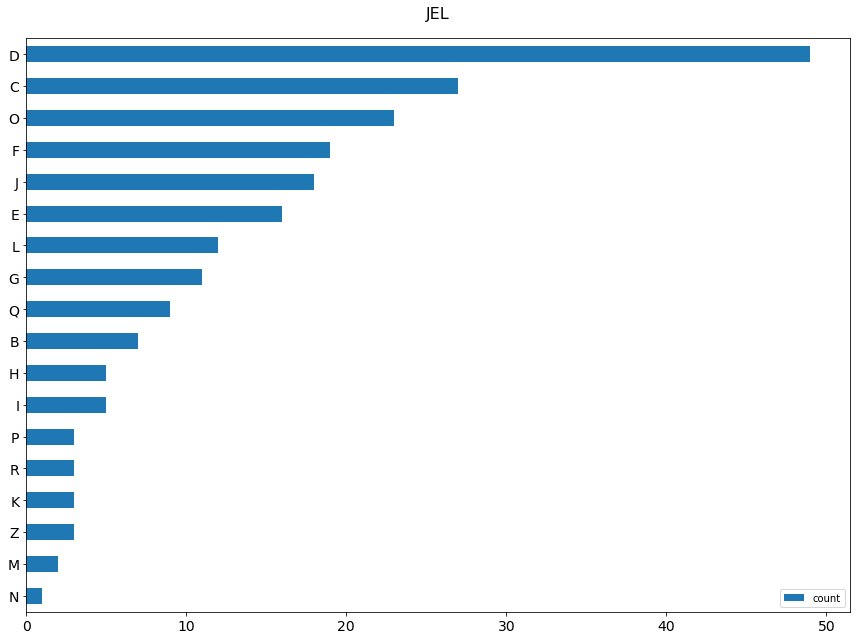

In [71]:
p = count_jels.sort_values(by=['count']).plot(
    kind='barh',
    title='JEL',
    x='jel_s_code',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 9),
    fontsize=14,
    rot=0,
)
p.set_title('JEL', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/jel_first_level_repartition.png')

## Funding

In [73]:
def funding_stats(dataframe: pd.core.frame.DataFrame,
                  filename: str,
                  columns: List[str],
                  occurence_params: Dict[str, Any] = dict(),
                  repartition_params: Dict[str, Any] = dict()):
    print(f'==> Start processing funding for output filename "{filename}" based on columns : {columns}')
    
    # Extract dataframe data
    exploded = dataframe.explode(columns)
    exploded = exploded[['uri_s'] + columns]
    exploded.dropna().to_csv(path_or_buf=f'./exports/fundings_{filename}_uri.csv', index=False)
    print(f'  ==> Saving CSV to "./exports/fundings_{filename}_uri.csv" (number of rows: {len(exploded.dropna().index)})')
    
    # Occurences stats
    occurence_exploded = exploded[columns].value_counts(dropna=True).to_frame(name='count').reset_index()
    occurence_exploded.to_csv(path_or_buf=f'./exports/fundings_{filename}_occurence.csv', index=False)
    print(f'  ==> Saving CSV to "./exports/fundings_{filename}_occurence.csv" (number of rows: {len(occurence_exploded.index)})')
    if not occurence_exploded.empty:
        occurence_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Occurence',
            ylabel='',
            labels=occurence_exploded[columns[0]],
            figsize=(12, 12),
            autopct='%1.1f%%',
            pctdistance=0.85,
            rotatelabels=True,
            labeldistance=1.02
        )
        occurence_exploded['count'].plot(**{**occurence_default_params, **occurence_params})
        plt.tight_layout()
        plt.figure(1).savefig(f'./exports/fundings_{filename}_occurence.png')
        plt.show()
        print(f'  ==> Saving figure to "./exports/fundings_{filename}_occurence.png"')
    else:
        print(f'  ==> Skip figure of occurence for "{filename}" as the dataframe is empty')
        
    
    # Repartition of having value
    count_exploded = exploded.dropna()[['uri_s']].value_counts().to_frame(name='count').reset_index()
    count_exploded = dataframe.merge(count_exploded, how='left', on='uri_s')
    count_exploded = count_exploded[['uri_s', 'count']].fillna(0).astype({'count': int}).drop_duplicates()
    count_exploded.to_csv(path_or_buf=f'./exports/fundings_{filename}_count.csv', index=False)
    print(f'Saving CSV to : ./exports/fundings_{filename}_count.csv (number of rows: {len(count_exploded.index)})')
    
    repartition_count_exploded = count_exploded[['count']].value_counts().to_frame(name='number_of_count').reset_index()
    repartition_count_exploded.to_csv(path_or_buf=f'./exports/fundings_{filename}_repartition.csv', index=False)
    print(f'Saving CSV to : ./exports/fundings_{filename}_repartition.csv (number of rows: {len(repartition_count_exploded.index)})')
    
    if not repartition_count_exploded.empty:
        repartition_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Repartition',
            ylabel='',
            labels=repartition_count_exploded['count'],
            figsize=(12, 12),
            autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * repartition_count_exploded['number_of_count'].sum() / 100)),
            pctdistance=0.8,
        )
        repartition_count_exploded['number_of_count'].plot(**{**repartition_default_params, **repartition_params})
        plt.tight_layout()
        plt.figure(1).savefig(f'./exports/fundings_{filename}_repartition.png')
        plt.show()
        print(f'Saving figure to "./exports/fundings_{filename}_repartition.png"')
    else:
        print(f'  ==> Skip figure of repartition for "{filename}" as the dataframe is empty')
    
    print(f'==> End processing funding for filemane "{filename}" outputs')


### Global

#### ANR

==> Start processing funding for output filename "anr_global" based on columns : ['anrProjectAcronym_s', 'anrProjectReference_s']
  ==> Saving CSV to "./exports/fundings_anr_global_uri.csv" (number of rows: 60)
  ==> Saving CSV to "./exports/fundings_anr_global_occurence.csv" (number of rows: 22)


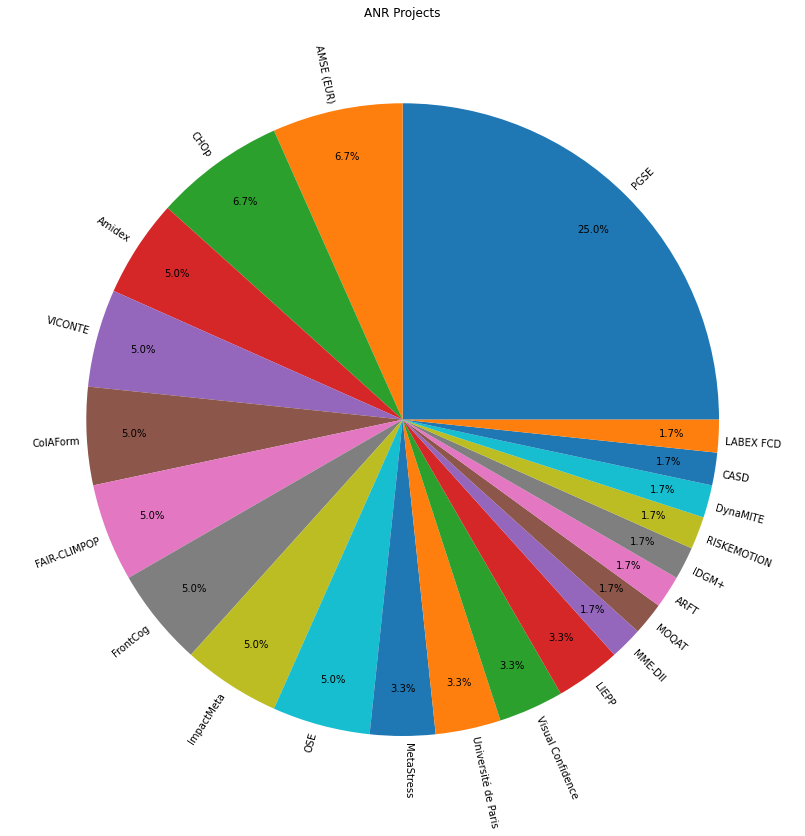

  ==> Saving figure to "./exports/fundings_anr_global_occurence.png"
Saving CSV to : ./exports/fundings_anr_global_count.csv (number of rows: 151)
Saving CSV to : ./exports/fundings_anr_global_repartition.csv (number of rows: 5)


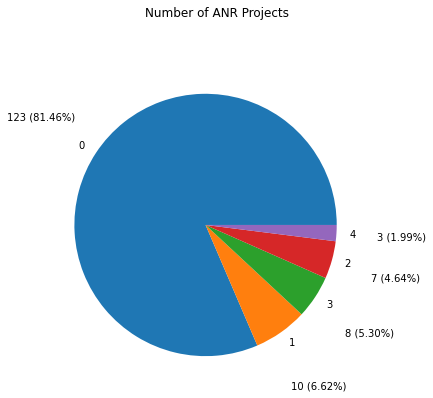

Saving figure to "./exports/fundings_anr_global_repartition.png"
==> End processing funding for filemane "anr_global" outputs


In [81]:
funding_stats(
    dataframe=df,
    columns=['anrProjectAcronym_s', 'anrProjectReference_s'],
    filename='anr_global',
    occurence_params=dict(title='ANR Projects'),
    repartition_params=dict(title='Number of ANR Projects', figsize=(6,6), pctdistance=1.5),
)

#### European

==> Start processing funding for output filename "european_global" based on columns : ['europeanProjectAcronym_s', 'europeanProjectReference_s']
  ==> Saving CSV to "./exports/fundings_european_global_uri.csv" (number of rows: 8)
  ==> Saving CSV to "./exports/fundings_european_global_occurence.csv" (number of rows: 7)


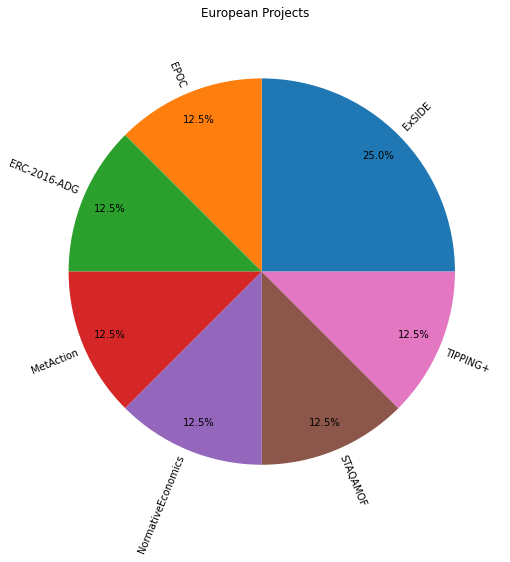

  ==> Saving figure to "./exports/fundings_european_global_occurence.png"
Saving CSV to : ./exports/fundings_european_global_count.csv (number of rows: 151)
Saving CSV to : ./exports/fundings_european_global_repartition.csv (number of rows: 3)


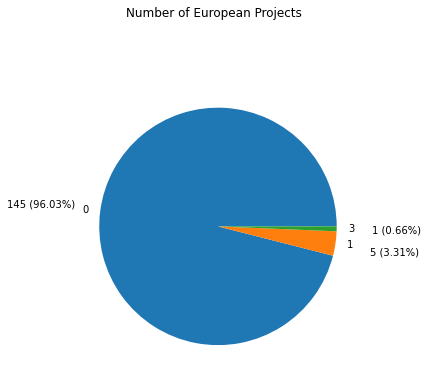

Saving figure to "./exports/fundings_european_global_repartition.png"
==> End processing funding for filemane "european_global" outputs


In [83]:
funding_stats(
    dataframe=df,
    columns=['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename='european_global',
    occurence_params=dict(title='European Projects', figsize=(8, 8)),
    repartition_params=dict(title='Number of European Projects', figsize=(6, 6), pctdistance=1.5),
)

#### Others

In [84]:
other_fundings = df.explode(['funding_s'])
other_fundings = other_fundings[['uri_s', 'funding_s']]
other_fundings.dropna().to_csv(path_or_buf='./exports/fundings_other_uri.csv', index=False)
other_fundings = other_fundings[['funding_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
other_fundings.to_csv(path_or_buf='./exports/fundings_other_stats.csv', index=False)
other_fundings.head(n=5)

,funding_s,count
0,NaN,127
1,The work of Eduardo Abi Jaber was supported by...,1
2,We also thank the Belgian French-speaking Comm...,1
3,This work was supported by the French National...,1
4,This work was supported by grants ANR-10-BLAN-...,1


## Collaborations

### Global


#### Structure/institution: Country (instStructCountry_s)

An article, may have several `instStructCountry_s`.

We explode the dataset based on the field `instStructCountry_s` to have only one country by row.

In [85]:
collaboration_struct_countries = df[['uri_s', 'instStructCountry_s']]
collaboration_struct_countries = collaboration_struct_countries.explode(['instStructCountry_s'])
collaboration_struct_countries

,uri_s,instStructCountry_s
0,https://halshs.archives-ouvertes.fr/halshs-033...,fr
0,https://halshs.archives-ouvertes.fr/halshs-033...,fr
0,https://halshs.archives-ouvertes.fr/halshs-033...,fr
1,https://hal-amu.archives-ouvertes.fr/hal-03620348,fr
1,https://hal-amu.archives-ouvertes.fr/hal-03620348,fr
...,...,...
150,https://hal.archives-ouvertes.fr/hal-03329190,fr
150,https://hal.archives-ouvertes.fr/hal-03329190,fr
150,https://hal.archives-ouvertes.fr/hal-03329190,fr
150,https://hal.archives-ouvertes.fr/hal-03329190,fr


In [86]:
collaboration_struct_country_values = collaboration_struct_countries[['instStructCountry_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_country_values.to_csv(f'./exports/colloborations_inst_struct_country.csv', index=False)
collaboration_struct_country_values.head(n=5)

,instStructCountry_s,count
0,fr,922
1,us,28
2,gb,18
3,de,12
4,nl,5


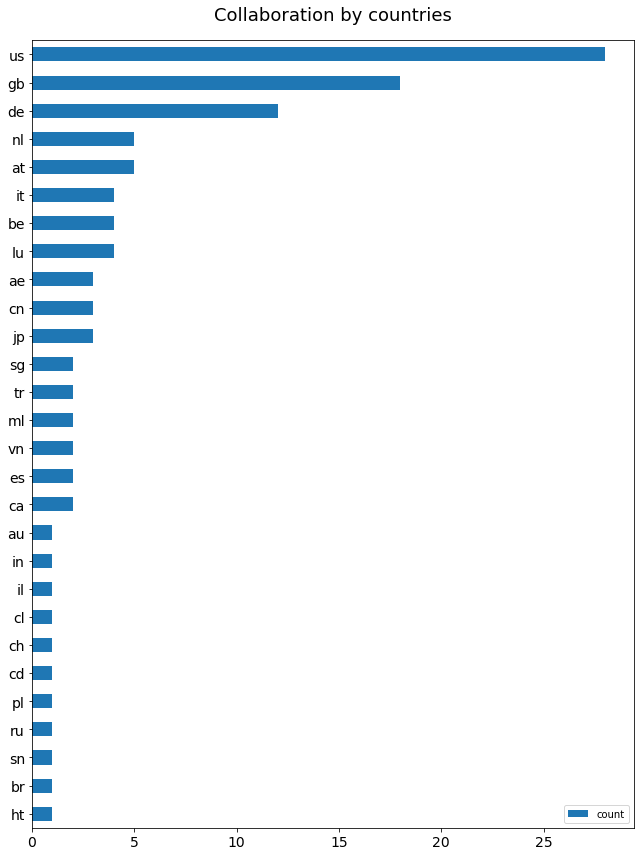

In [87]:
p = collaboration_struct_country_values[(collaboration_struct_country_values.instStructCountry_s != 'fr')].sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Collaboration by countries',
    x='instStructCountry_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(9, 12),
    fontsize=14,
    rot=0,
)
p.set_title('Collaboration by countries',pad=20, fontdict={'fontsize':18})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_country_count.png')

#### Structure/institution: Name (instStructName_s)

An article, may have several `instStructName_s`.

We explode the dataset based on the field `instStructName_s` to have only one structure by row.

In [88]:
collaboration_struct_names = df[['uri_s', 'instStructName_s']]
collaboration_struct_names = collaboration_struct_names.explode(['instStructName_s'])
collaboration_struct_names

,uri_s,instStructName_s
0,https://halshs.archives-ouvertes.fr/halshs-033...,Institut de recherches économiques et sociales
0,https://halshs.archives-ouvertes.fr/halshs-033...,Université Paris 1 Panthéon-Sorbonne
0,https://halshs.archives-ouvertes.fr/halshs-033...,Centre National de la Recherche Scientifique
1,https://hal-amu.archives-ouvertes.fr/hal-03620348,École des hautes études en sciences sociales
1,https://hal-amu.archives-ouvertes.fr/hal-03620348,Aix Marseille Université
...,...,...
150,https://hal.archives-ouvertes.fr/hal-03329190,École des hautes études en sciences sociales
150,https://hal.archives-ouvertes.fr/hal-03329190,École des Ponts ParisTech
150,https://hal.archives-ouvertes.fr/hal-03329190,Centre National de la Recherche Scientifique
150,https://hal.archives-ouvertes.fr/hal-03329190,Institut National de Recherche pour l’Agricult...


In [116]:
collaboration_struct_name_aggregation_min = 3
collaboration_struct_name_values = collaboration_struct_names[['instStructName_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name.csv', index=False)
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Centre National de la Recherche Scientifique')]
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Université Paris 1 Panthéon-Sorbonne')]
# Retrieve small collaboration to create a new row 'others'
collaboration_struct_name_others = collaboration_struct_name_values[(collaboration_struct_name_values['count'] <= collaboration_struct_name_aggregation_min)]
collaboration_struct_name_others_size = collaboration_struct_name_others['instStructName_s'].size
collaboration_struct_name_others = pd.DataFrame(
    dict(
        instStructName_s=f'Others ({collaboration_struct_name_others_size})',
        count=collaboration_struct_name_others['count'].sum()
    ),
    index=[0]
)
# Cleanup base df for collaboration
collaboration_struct_name_top = collaboration_struct_name_values[(collaboration_struct_name_values['count'] > collaboration_struct_name_aggregation_min)]
collaboration_struct_name_values = collaboration_struct_name_top.append(collaboration_struct_name_others)
collaboration_struct_name_values = collaboration_struct_name_values.sort_values(by=['count'], ascending=False)
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name_filtered_{collaboration_struct_name_aggregation_min}.csv', index=False)
collaboration_struct_name_values.head(n=5)

/tmp/ipykernel_98/2332021996.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collaboration_struct_name_values = collaboration_struct_name_top.append(collaboration_struct_name_others)


,instStructName_s,count
0,Others (144),201
2,École normale supérieure - Paris,67
3,École des hautes études en sciences sociales,66
4,Institut National de Recherche pour l’Agricult...,58
5,École des Ponts ParisTech,57


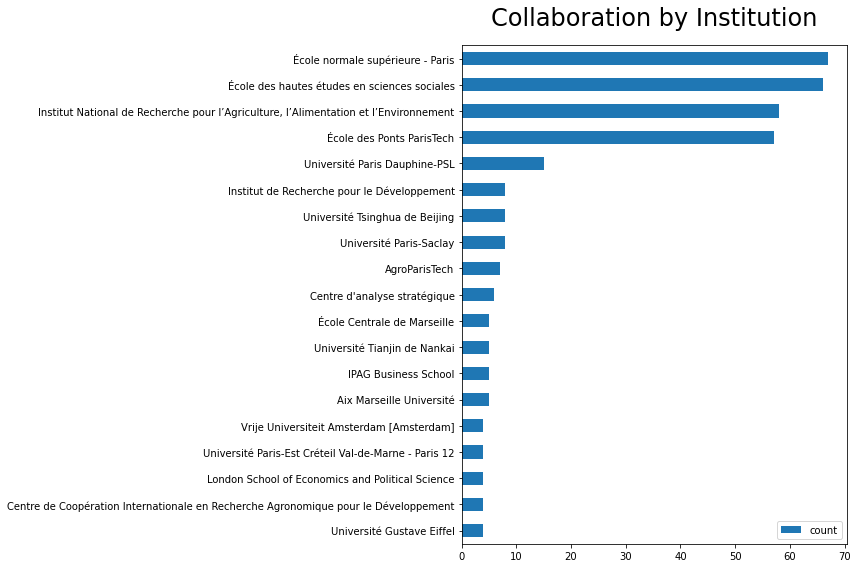

In [117]:
p = collaboration_struct_name_top.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institution',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 8)
)
p.set_title('Collaboration by Institution', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count_without_others.png')

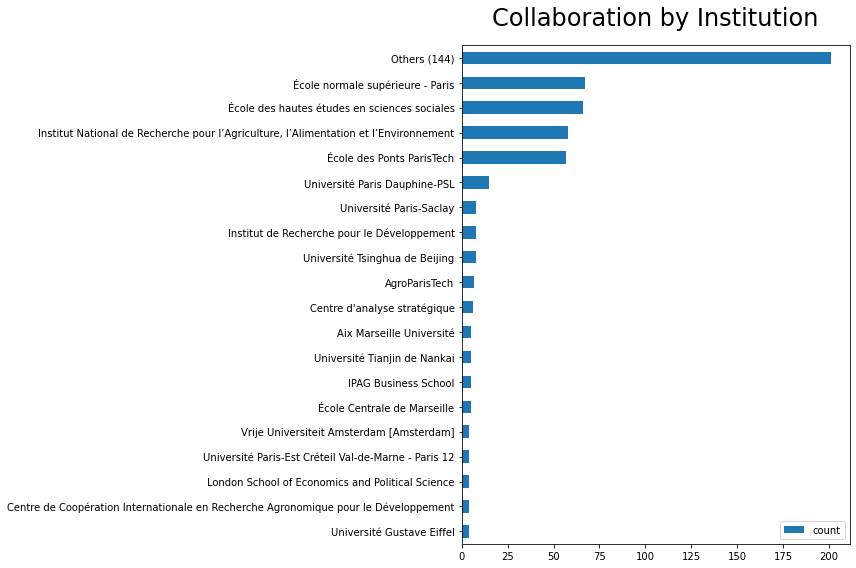

In [112]:
p = collaboration_struct_name_values.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institution',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 8)
)
p.set_title('Collaboration by Institution', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count.png')

## Attached files

Also named Full text

An article may have multiple attached files. We will count the number of attached files here by document.

In [118]:
def full_text(dataframe, filename: str, title: str, params: Dict[str, Any] = dict()):
    attached_files = dataframe[['uri_s', 'files_s']].copy()
    attached_files['attached_files_count'] = attached_files['files_s'].apply(lambda x: len(x) if pd.notnull(x) else 0)
    attached_files[['uri_s', 'attached_files_count']].to_csv(f'./exports/full_text_{filename}.csv', index=False)
    print(f'Saving CSV to : ./exports/full_text_{filename}.csv')
     
    attached_files_number = attached_files['attached_files_count'].value_counts().sort_index()
    attached_files_number.to_csv(f'./exports/full_text_{filename}_repartition.csv', index=False)
    print(f'Saving figure to : ./exports/full_text_{filename}_repartition.csv')
    
    default_params = dict(   
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        title=title,
        ylabel='',
        labels=attached_files_number.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * attached_files_number.sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    p = attached_files_number.plot(**{**default_params, **params})
    plt.tight_layout()
    plt.figure(1).savefig(f'./exports/full_text_{filename}_repartition.png')
    plt.show()
    print(f'Saving figure to : ./exports/full_text_{filename}_repartition.png')
    return attached_files 

### Global

Saving CSV to : ./exports/full_text_global.csv
Saving figure to : ./exports/full_text_global_repartition.csv


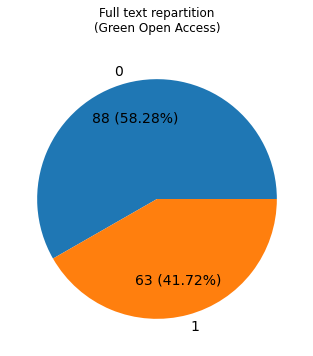

Saving figure to : ./exports/full_text_global_repartition.png


,uri_s,files_s,attached_files_count
0,https://halshs.archives-ouvertes.fr/halshs-033...,NaN,0
1,https://hal-amu.archives-ouvertes.fr/hal-03620348,NaN,0
2,https://hal-sciencespo.archives-ouvertes.fr/ha...,[https://hal-sciencespo.archives-ouvertes.fr/h...,1
3,https://hal.archives-ouvertes.fr/hal-03233310,NaN,0
4,https://hal.archives-ouvertes.fr/hal-03131121,NaN,0
...,...,...,...
146,https://halshs.archives-ouvertes.fr/halshs-033...,[https://halshs.archives-ouvertes.fr/halshs-03...,1
147,https://halshs.archives-ouvertes.fr/halshs-033...,[https://halshs.archives-ouvertes.fr/halshs-03...,1
148,https://halshs.archives-ouvertes.fr/halshs-036...,[https://halshs.archives-ouvertes.fr/halshs-03...,1
149,https://halshs.archives-ouvertes.fr/halshs-036...,NaN,0


In [127]:
full_text(df, filename='global', title='Full text repartition\n(Green Open Access)', params=dict(figsize=(5,5), pctdistance=0.70, labeldistance=1.1))

## Open Access

In [123]:
def open_access(dataframe, filename: str, title: str, params: Dict[str, Any] = dict()):
    open_access_number_series = dataframe['openAccess_bool'].value_counts().reindex([True, False])
    open_access_number = open_access_number_series.to_frame(name='count').reset_index()
    open_access_number.to_csv(f'./exports/open_access_{filename}_repartition.csv', index=False)
    print(f'Saving figure to : ./exports/open_access_{filename}_repartition.csv')
    
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        title=title,
        ylabel='',
        labels=open_access_number_series.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * open_access_number['count'].sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    p = open_access_number_series.plot(**{**default_params, **params})
    plt.tight_layout()
    plt.figure(1).savefig(f'./exports/open_access_{filename}_repartition.png')
    plt.show()
    print(f'Saving figure to : ./exports/open_access_{filename}_repartition.png')
    
    return open_access_number

### Global

Saving figure to : ./exports/open_access_global_repartition.csv


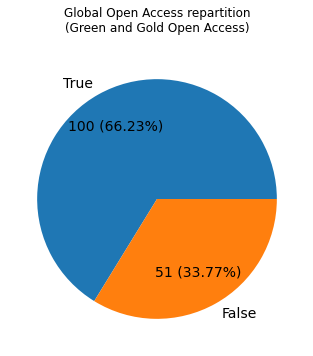

Saving figure to : ./exports/open_access_global_repartition.png


,index,count
0,True,100
1,False,51


In [126]:
open_access(df, filename='global', title='Global Open Access repartition\n(Green and Gold Open Access)', params=dict(figsize=(5,5), pctdistance=0.70, labeldistance=1.1))

## Ranking



In [128]:
def create_ranking_journals_df(dataframe: pd.core.frame.DataFrame, filename: str = None):
    ranking_journals = dataframe[['uri_s', 'journalTitle_s', 'journalIssn_s']].copy()
    ranking_journals['ISSN'] = ranking_journals['journalIssn_s']
    # Econlit
    ranking_journals = ranking_journals.merge(econlit_df, how='left', on='ISSN', validate='many_to_one')
    ranking_journals['ECONLIT'] = ranking_journals['Title'].notnull()
    ranking_journals = ranking_journals.drop(columns=['Title'])
    # MathSciNet
    ranking_journals = ranking_journals.merge(mathscinet_df, how='left', on='ISSN', validate='many_to_one')
    ranking_journals['MATHSCINET'] = ranking_journals['Title'].notnull()
    ranking_journals = ranking_journals.drop(columns=['Title'])
    # Scimago
    ranking_journals = ranking_journals.merge(scimagojr_df, how='left', on='ISSN', validate='many_to_one')
    ranking_journals['SCIMAGO'] = ranking_journals['Title'].notnull()
    ranking_journals = ranking_journals.drop(columns=['Title']).rename(columns={'CATEGORIES': 'SCIMAGO_CATEGORIES'})
    # HCERES
    ranking_journals = ranking_journals.merge(hceres_df, how='left', on='ISSN', validate='many_to_one')
    ranking_journals = ranking_journals.drop(columns=['Title'])
    ranking_journals['HCERES'] = ranking_journals['HCERES_2021'].notnull()
    ranking_journals = ranking_journals.rename(columns={'HCERES_2021': 'HCERES_RANK', 'CoNRS_2020': 'HCERES_CONRS_RANK', 'FNEGE_2019': 'HCERES_FNEGE_RANK'})
    # HCERES + Scimago + MathSciNet + Econlit
    ranking_journals['NUMBER_OF_REFERENTIALS'] = ranking_journals[['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES']].apply(lambda x: x.sum(), axis=1, raw=True)
    
    # Cleanup data
    ranking_journals = ranking_journals.drop(columns=['ISSN'])
    if filename:
        ranking_journals.to_csv(f'./exports/rankings_{filename}.csv', index=False)
        print(f'  ==> Saved CSV at "./exports/rankings_{filename}.png"')
    return ranking_journals

In [129]:
def journals_ranking_plot(dataframe: pd.core.frame.DataFrame, title: str, filename: str):
    columns = ['MATHSCINET', 'SCIMAGO', 'ECONLIT', 'HCERES']
    dataframe[['uri_s'] + columns].to_csv(f'./exports/rankings_{filename}_filtered.csv', index=False)
    
    ranking_aggregation_transposed = dataframe[columns].apply(pd.Series.value_counts).transpose().fillna(0)
    ranking_aggregation_transposed.to_csv(f'./exports/rankings_{filename}_count.csv', index=True)
    print(f'  ==> Saved CSV at "./exports/rankings_{filename}_count.csv"')

    true_values = ranking_aggregation_transposed[True].tolist()
    true_labels = round(100 * ranking_aggregation_transposed[True] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    true_labels = ranking_aggregation_transposed[True].combine(true_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    false_values = ranking_aggregation_transposed[False].tolist()
    false_labels = round(100 * ranking_aggregation_transposed[False] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    false_labels = ranking_aggregation_transposed[False].combine(false_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    ind = np.arange(len(true_values)) 
    width = 0.60

    fig, ax = plt.subplots(figsize=(12,6))

    true_plot = ax.barh(columns, true_values, width, label='True', linewidth=0 )
    false_plot = ax.barh(columns, false_values, width, left=true_values, label='False', linewidth=0)

    ax.set_title(f'{title} articles ranking', fontsize=18)
    ax.set_xlabel('Articles', fontsize=13)
    ax.bar_label(true_plot, label_type='center', fontsize=13, labels=true_labels)
    ax.bar_label(false_plot, label_type='center', fontsize=13, labels=false_labels)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=13)
    fig.tight_layout()
    fig.savefig(f'./exports/rankings_{filename}_general.png')
    print(f'  ==> Saved figure at "./exports/rankings_{filename}_general.png"')
    plt.show()

In [130]:
def hceres_ranking_plot(dataframe: pd.core.frame.DataFrame, title: str, filename: str, params:Dict[str, Any] = dict()):
    print(f'==> Create ranking plot {title} for HCERES (filemane={filename}, params={params})')
    hceres_rankings = dataframe['HCERES_RANK'].dropna().value_counts().sort_index()
    hceres_rankings.to_frame(name='count_hceres_ranks').to_csv(f'./exports/rankings_{filename}_hceres.csv', index=False)
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=hceres_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * hceres_rankings.sum() / 100)),
        pctdistance=0.6,
        fontsize=14,
    )
    hceres_rankings.plot(**{**default_params, **params})
    plt.figure(1).axes[0].set_title(f'{title} HCERES articles ranking', pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(f'./exports/rankings_{filename}_hceres.png')
    print(f'  ==> Saved figure at "./exports/rankings_{filename}_hceres.png"')
    plt.show()

In [131]:
def create_scimajo_df(dataframe: pd.core.frame.DataFrame, filename: str, suffix: int = 0, quantile: float = 0.0):
    scimagojr_categories = dataframe[['uri_s', 'journalTitle_s', 'SCIMAGO_CATEGORIES']].copy().dropna()
    scimagojr_categories['CATEGORY'] = scimagojr_categories['SCIMAGO_CATEGORIES'].str.split(';')
    scimagojr_categories = scimagojr_categories.explode('CATEGORY')
    scimagojr_categories['CATEGORY'] = scimagojr_categories['CATEGORY'].str.strip()
    scimagojr_categories['SCIMAGO_JOURNAL_RANKING'] = scimagojr_categories['CATEGORY'].str.extract('^.*\((?P<sjr>Q[1-4])\)\s*$')
    scimagojr_categories['CATEGORY_WITHOUT_SJR'] = scimagojr_categories['CATEGORY'].str.extract('^(?P<cat>.*)\s+\(Q[1-4]\)\s*$')
    scimagojr_categories = scimagojr_categories.reset_index(drop=True)
    scimagojr_categories.to_csv(f'./exports/rankings_{filename}_scimago.csv', index=False)
    print(f'  ==> Saved CSV at "./exports/rankings_{filename}_scimago.csv"')
    
    # Add a category others when we have to small values
    if quantile > 0:
        print(f'  ==> Rework dataframe to group the less used categories (quantile={quantile})')
        scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts()
        bottom_value = scimagojr_category_names.quantile(q=quantile)
        less_freq_scimagojr_category_names = scimagojr_category_names[scimagojr_category_names <= bottom_value]
        scimagojr_categories.loc[scimagojr_categories['CATEGORY_WITHOUT_SJR'].isin(less_freq_scimagojr_category_names.index.tolist())] = "Others"
    
    
    scimagojr_categories.to_csv(f'./exports/rankings_{filename}_scimago_filtered_{suffix}.csv', index=False)
    print(f'  ==> Saved CSV at "./exports/rankings_{filename}_scimago_filtered_{suffix}.csv"')
    
    # Create a new column with category with percent (for the occurence of this category)
    scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts().to_frame().reset_index()
    scimagojr_category_names = scimagojr_category_names.rename(columns={'index': 'CATEGORY_WITHOUT_SJR', 'CATEGORY_WITHOUT_SJR': 'CATEGORY_WITHOUT_SJR_COUNT'})
    scimagojr_category_names['CATEGORY_WITHOUT_JSR_PERCENT'] = scimagojr_category_names.apply(lambda row: '{n} - {v} ({p}%)'.format(
        n=row['CATEGORY_WITHOUT_SJR'],
        v=row['CATEGORY_WITHOUT_SJR_COUNT'],
        p=round(100 * row['CATEGORY_WITHOUT_SJR_COUNT'] / scimagojr_category_names['CATEGORY_WITHOUT_SJR_COUNT'].sum(), 1)
    ), axis='columns')

    # Merge with initial dataframe
    scimagojr_categories = scimagojr_categories.merge(scimagojr_category_names, how='inner', on=['CATEGORY_WITHOUT_SJR'])
    
    return scimagojr_categories

In [132]:
def scimago_ranking_plot(dataframe: pd.core.frame.DataFrame, title: str, filename: str, suffix: int = 0, category_params:Dict[str, Any] = dict()):
    # Fig 1 : Category
    scimago_category_names = dataframe['CATEGORY_WITHOUT_JSR_PERCENT'].value_counts()
    default_category_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimago_category_names.index.tolist(),
        figsize=(18, 12),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimago_category_names.sum() / 100)),
        pctdistance=0.9,
        labeldistance=None,
        legend=True
    )
    scimago_category_names.plot(**{**default_category_params, **category_params})
    plt.legend(loc='best', bbox_to_anchor=(0.1, 0.9))
    plt.figure(1).axes[0].set_title(f'{title} SCImago Categories', pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(f'./exports/rankings_{filename}_scimago_categories_{suffix}.png')
    print(f'  ==> Saved figure at "./exports/rankings_{filename}_scimago_categories_{suffix}.png"')
    plt.show()
    
    # Fig 2 : SJR Repartition
    scimajo_journal_rankings = dataframe['SCIMAGO_JOURNAL_RANKING'].value_counts()
    scimajo_journal_rankings.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimajo_journal_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimajo_journal_rankings.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    plt.figure(1).axes[0].set_title(f'{title} SCImago Journal Ranking', pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(f'./exports/rankings_{filename}_scimago_sjr_q_score_{suffix}.png')
    print(f'  ==> Saved figure at "./exports/rankings_{filename}_scimago_sjr_q_score_{suffix}.png"')
    plt.show()

In [133]:
def cross_referentials_plot(dataframe: pd.core.frame.DataFrame, title: str, filename: str):
    cross_ref_s = dataframe['NUMBER_OF_REFERENTIALS'].value_counts().sort_index()
    cross_ref_s.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=cross_ref_s.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * cross_ref_s.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    plt.figure(1).axes[0].set_title(f'{title} distribution of articles\nin journal classification referentials', pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(f'./exports/rankings_{filename}_distribution_of_articles_in_journal_classification_referentials.png')
    print(f'  ==> Saved figure at "./exports/rankings_{filename}_distribution_of_articles_in_journal_classification_referentials.png"')
    plt.show()

In [134]:
def scimago_hceres_matrix(dataframe: pd.core.frame.DataFrame, filename: str):
    print(f'==> Create Scimago / HCERES matrix (filemane={filename})')
    ranking_scimago_hceres_df = dataframe[['HCERES_RANK', 'SJR_BEST_QUARTILE']].fillna('NON REFERENCE')
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.value_counts(dropna=False)
    ranking_scimago_hceres_df.to_excel(f'./exports/rankings_{filename}_hceres_scimago_matrix.xlsx')
    print(f'  ==> Saved Excel at "./exports/rankings_{filename}_hceres_scimago_matrix.xlsx"')
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.unstack(fill_value=0)
    ranking_scimago_hceres_df.to_excel(f'./exports/rankings_{filename}_hceres_scimago_matrix_2.xlsx')
    print(f'  ==> Saved Excel at "./exports/rankings_{filename}_hceres_scimago_matrix_2.xlsx"')
    return ranking_scimago_hceres_df

In [135]:
def rankings(dataframe: pd.core.frame.DataFrame,
             title: str,
             filename: str,
             hceres_category_params: Dict[str, Any] = dict()):
    print(f'==> Process generic ranking for {title} (filemane={filename})')
    rankings_journals = create_ranking_journals_df(dataframe, filename=filename)
    journals_ranking_plot(rankings_journals, title=title, filename=filename)
    hceres_ranking_plot(rankings_journals, title=title, filename=filename, params=hceres_category_params)
    cross_referentials_plot(rankings_journals, title=title, filename=filename)
    return rankings_journals

In [136]:
def scimago_rankings(dataframe: pd.core.frame.DataFrame,
                     title: str,
                     filename: str,
                     suffix: int = 0,
                     quantile: float = 0.0,
                     category_params: Dict[str, Any] = dict()):
    # The input dataframe should be a return of create_ranking_journals_df or rankings
    print(f'==> Process scimago ranking for {title} (filemane={filename})') 
    scimajo_df = create_scimajo_df(dataframe, filename=filename, suffix=suffix, quantile=quantile)
    scimago_ranking_plot(scimajo_df, title=title, filename=filename, suffix=suffix, category_params=category_params)

### Global

==> Process generic ranking for Global (filemane=global)
  ==> Saved CSV at "./exports/rankings_global.png"
  ==> Saved CSV at "./exports/rankings_global_count.csv"
  ==> Saved figure at "./exports/rankings_global_general.png"


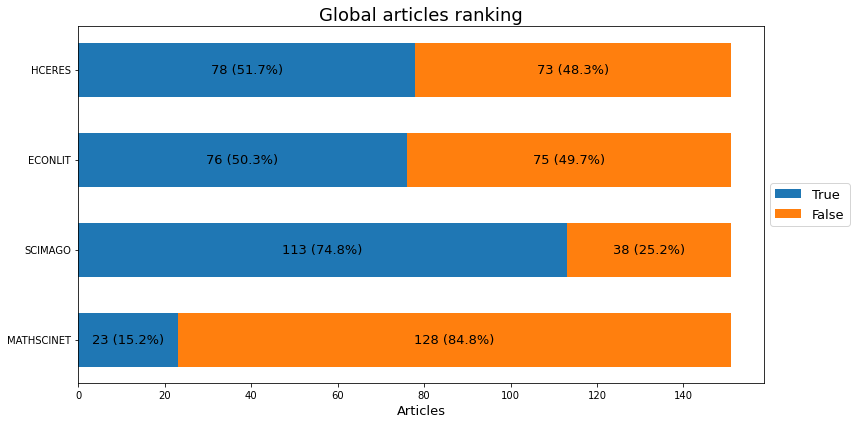

==> Create ranking plot Global for HCERES (filemane=global, params={})
  ==> Saved figure at "./exports/rankings_global_hceres.png"


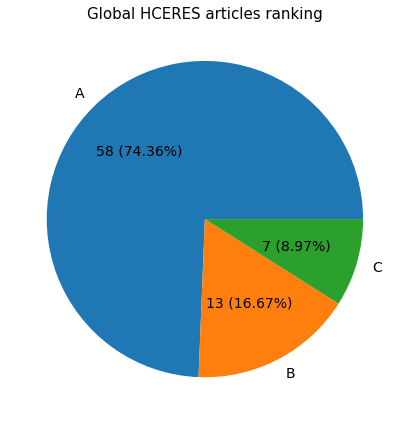

  ==> Saved figure at "./exports/rankings_global_distribution_of_articles_in_journal_classification_referentials.png"


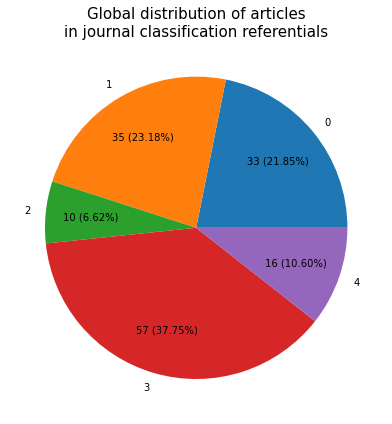

==> Create Scimago / HCERES matrix (filemane=global)
  ==> Saved Excel at "./exports/rankings_global_hceres_scimago_matrix.xlsx"
  ==> Saved Excel at "./exports/rankings_global_hceres_scimago_matrix_2.xlsx"
==> Process scimago ranking for Global (filemane=global)
  ==> Saved CSV at "./exports/rankings_global_scimago.csv"
  ==> Rework dataframe to group the less used categories (quantile=0.6)
  ==> Saved CSV at "./exports/rankings_global_scimago_filtered_0.csv"
  ==> Saved figure at "./exports/rankings_global_scimago_categories_0.png"


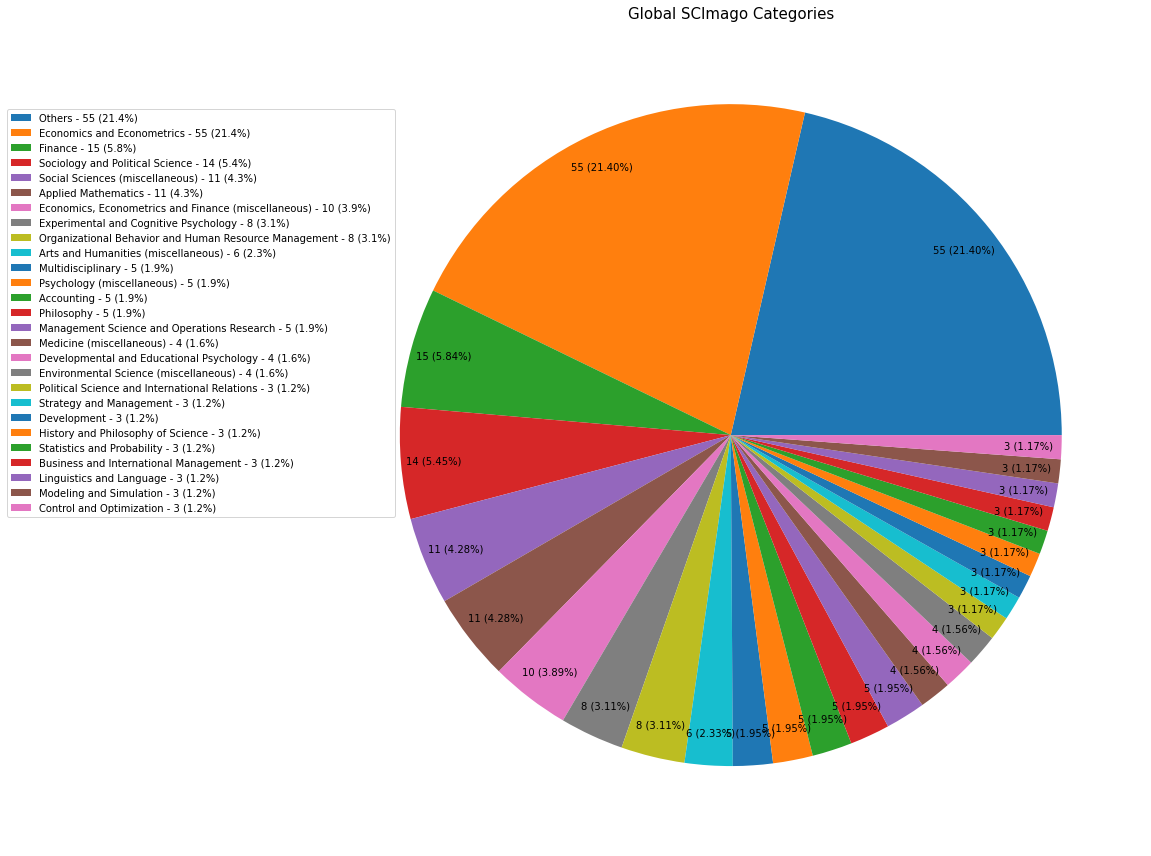

  ==> Saved figure at "./exports/rankings_global_scimago_sjr_q_score_0.png"


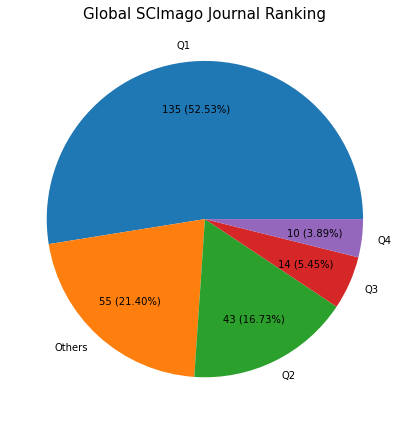

,uri_s,journalTitle_s,journalIssn_s,ECONLIT,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,HCERES_CONRS_RANK,HCERES_FNEGE_RANK,HCERES_RANK,HCERES,NUMBER_OF_REFERENTIALS
0,https://halshs.archives-ouvertes.fr/halshs-033...,Industrial Relations Journal,0019-8692,False,False,Industrial Relations (Q2),Q2,True,NaN,NaN,NaN,False,1
1,https://hal-amu.archives-ouvertes.fr/hal-03620348,Defence and Peace Economics,1024-2694,True,False,Economics and Econometrics (Q2); Social Scienc...,Q2,True,4,NaN,C,True,3
2,https://hal-sciencespo.archives-ouvertes.fr/ha...,LIEPP Policy Brief,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0
3,https://hal.archives-ouvertes.fr/hal-03233310,Recherches Internationales,0294-3069,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0
4,https://hal.archives-ouvertes.fr/hal-03131121,Journal of Financial Econometrics,1479-8409,True,False,Economics and Econometrics (Q1); Finance (Q1),Q1,True,2,NaN,A,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,https://halshs.archives-ouvertes.fr/halshs-033...,Proceedings of the National Academy of Science...,0027-8424,True,True,Multidisciplinary (Q1),Q1,True,NaN,NaN,NaN,False,3
147,https://halshs.archives-ouvertes.fr/halshs-033...,Actuel Marx,0994-4524,False,False,Philosophy (Q3); Economics and Econometrics (Q...,Q3,True,NaN,NaN,NaN,False,1
148,https://halshs.archives-ouvertes.fr/halshs-036...,Frontiers in Psychology,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0
149,https://halshs.archives-ouvertes.fr/halshs-036...,Health Policy and Planning,0268-1080,True,False,Health Policy (Q1),Q1,True,4,3,B,True,3


In [138]:
ranking_df = rankings(df, title='Global', filename='global')
scimago_hceres_matrix(ranking_df, filename='global')
scimago_rankings(ranking_df, title='Global', filename='global', quantile=0.6)
ranking_df